In [1]:
import sys

# New Section

In [2]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/MyDrive/PS1/']
### ========== TODO : END ========== ###


In [4]:
from nutil import *

In [5]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [6]:
######################################################################
# Immutatble classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [7]:
######################################################################
# Mutatble classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set

        self.probabilities_ = np.sum(y)/len(y)

        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)

        y = np.random.choice(
            [0, 1],
            size=len(X),
            replace=True,
            p=[1-self.probabilities_, self.probabilities_])

        # y = np.random.choice(
        #     [1, 0],
        #     size=len(X),
        #     replace=True,
        #     p=[self.probabilities_, 1-self.probabilities_])

        ### ========== TODO : END ========== ###

        return y


In [8]:
######################################################################
# Immutatble functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [9]:
######################################################################
# Mutatble functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use train_test_split (be careful of the parameters)

    train_error_ls = []
    test_error_ls = []
    f1_score_ls = []
    sss = StratifiedShuffleSplit(n_splits=ntrials, random_state=0, test_size=test_size)
    for i, (train_index, test_index) in enumerate(sss.split(X, y)):
      clf.fit(X[train_index], y[train_index])
      y_pred_train = clf.predict(X[train_index])
      y_pred_test = clf.predict(X[test_index])

      train_error_ls += [1 - metrics.accuracy_score(y[train_index], y_pred_train, normalize=True)]
      test_error_ls += [1 - metrics.accuracy_score(y[test_index], y_pred_test, normalize=True)]
      f1_score_ls += [metrics.f1_score(y[test_index], y_pred_test, average='micro')]

    train_error = np.mean(train_error_ls)
    test_error = np.mean(test_error_ls)
    f1_score = np.mean(f1_score_ls)


    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [10]:
######################################################################
# Immutatble functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Plotting...
Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
0.24
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- training error: 0.153
	-- training error: 0.195
	-- training error: 0.213
Investigating various classifiers...
(0.24, 0.24, 0.7600000000000001)
(0.37477499999999997, 0.38199999999999995, 0.618)
(0.0, 0.20475, 0.79525)
(0.20167499999999997, 0.25915, 0.7408499999999999)
Finding the best k...


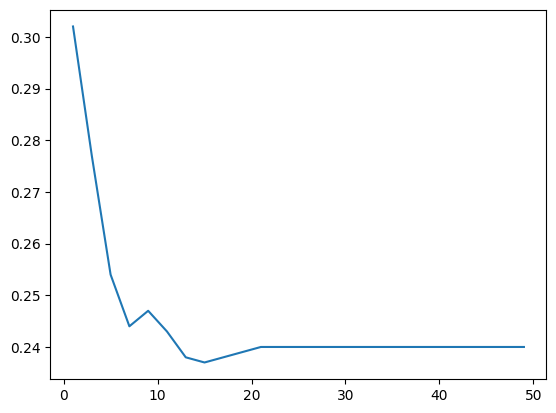

best k: 15
Investigating depths...


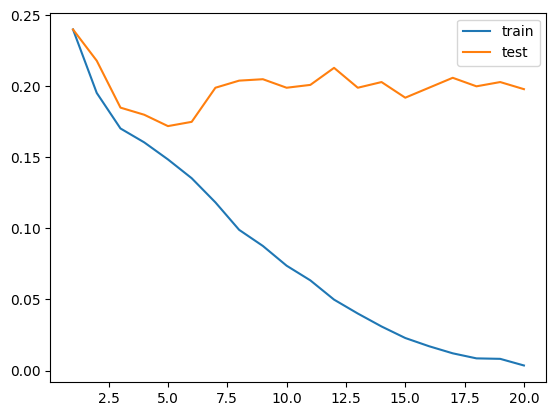

best depth limit: 5


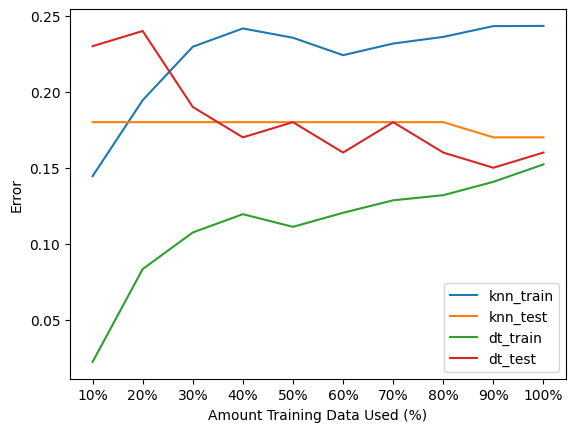

Done


In [11]:

######################################################################
# main
######################################################################


def main():



    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    data_file =  "/content/drive/MyDrive/PS1/adult_subsample.csv"
    ### ========== TODO : END ========== ###


    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features




    #========================================
    # part a: plot histograms of each feature
    print('Plotting...')
    # plot_histograms (X, y, Xnames=Xnames, yname=yname)
    # plt.show()




    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)

    # X =
    # scaler = StandardScaler()
    # scaler.fit(X)
    # X = scaler.transform(X)

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')

    clf = RandomClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    print(clf.probabilities_)
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    clf = DecisionTreeClassifier(criterion='entropy') # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')

    # print the error for each k
    for k in [3, 5, 7]:
      clf = KNeighborsClassifier(n_neighbors=k)
      clf.fit(X, y)                  # fit training data using the classifier
      y_pred = clf.predict(X)        # take the classifier and run it on the training data
      train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
      print('\t-- training error: %.3f' % train_error)


    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    for clf in [
        MajorityVoteClassifier(),
        RandomClassifier(),
        DecisionTreeClassifier(criterion='entropy'),
        KNeighborsClassifier(n_neighbors=5)]:
      summary = error(clf, X, y, ntrials=100)
      print(summary)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    errs = []
    ks = list(range(1, 50, 2))
    for k in ks:
      clf = KNeighborsClassifier(n_neighbors=k)
      res = cross_val_score(clf, X, y, cv=10, verbose=0)
      errs += [1-np.mean(res)]

    plt.figure()
    plt.plot(ks, errs)
    plt.show()
    print("best k: %d" % (1+2*np.argmin(errs)))



    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')

    test_errs = []
    train_errs = []
    ds = list(range(1, 21))
    for d in ds:
      clf = DecisionTreeClassifier(max_depth=d, criterion='entropy')
      res = cross_validate(clf, X, y, cv=10, verbose=0, return_train_score=True)

      test_errs += [1-np.mean(res['test_score'])]
      train_errs += [1-np.mean(res['train_score'])]

    plt.figure()
    plt.plot(ds, train_errs, label='train')
    plt.plot(ds, test_errs, label='test')
    plt.legend()
    plt.show()
    print("best depth limit: %d" % (1+np.argmin(test_errs)))

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes

    # isplit = len(y)//10*9
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=0)
    # Xtrain, Xtest = X[:isplit], X[isplit:]
    # ytrain, ytest = y[:isplit], y[isplit:]

    dstar = 5
    kstar = 15
    stepsize = len(ytrain)//10

    dt_train = []
    dt_test = []
    knn_train = []
    knn_test = []
    steps = list(range(1, 10+1))
    for step in steps:
      Xsub, ysub = Xtrain[:stepsize*step], ytrain[:stepsize*step]

      knn = KNeighborsClassifier(n_neighbors=kstar)
      knn.fit(Xsub, ysub)
      knn_test  += [1 - metrics.accuracy_score(ytest, knn.predict(Xtest), normalize=True)]
      knn_train += [1 - metrics.accuracy_score(ysub, knn.predict(Xsub), normalize=True)]

      dt = DecisionTreeClassifier(max_depth=dstar)
      dt.fit(Xsub, ysub)
      dt_test += [1 - metrics.accuracy_score(ytest, dt.predict(Xtest), normalize=True)]
      dt_train += [1 - metrics.accuracy_score(ysub, dt.predict(Xsub), normalize=True)]

    plt.figure()
    plt.plot(steps, knn_train, label='knn_train')
    plt.plot(steps, knn_test, label='knn_test')
    plt.plot(steps, dt_train, label='dt_train')
    plt.plot(steps, dt_test, label='dt_test')
    plt.xticks(steps, ['%d%%' % (s*10) for s in steps])
    plt.legend()
    plt.ylabel('Error')
    plt.xlabel('Amount Training Data Used (%)')
    plt.show()

    ### ========== TODO : END ========== ###



    print('Done')


if __name__ == "__main__":
    main()
